# Adding modes 

## This script does the following

* While increasing the number of modes on domain 2 and the interface, we compute the solutions for the hybrid-NL and surrogate-NL
* Report the errors of the latter

# Import libraries and load functions

In [1]:
%run functions.ipynb

from matplotlib.ticker import MaxNLocator

# Create FOM snapshots and 100 test samples

In [2]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

# Boolean alreadyrun 
# 1 if the variables are already computed
# 0 else

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
        
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train = pickle.load(file)
        
ndofs_U1 = np.shape(S1)[0]
ndofs_U2 = np.shape(S2)[0]
ndofs_UI = np.shape(SI)[0]

# POD analysis

Snapshot energy domain 1: 0.9666179772016339
Snapshot energy domain 2: 0.9988895601498222
Snapshot energy interface: 0.9976539858408728


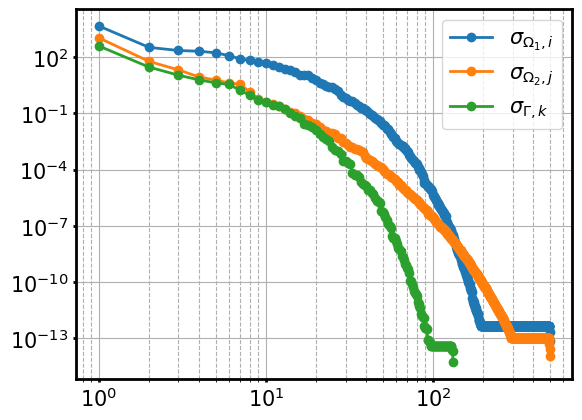

In [31]:
# Choose the number of modes
cutoff1 = 10

# Choose max number of modes
cutoffI = 10
cutoff2 = 10

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

# Generate $\tilde{\mathcal{T}}_{n_s}$ and $\{ t_\Gamma(\mu^i)  \}_{i=1}^{n_s}$

In [32]:
a_1I_array = np.zeros((nsamples,ndofs_u1,ndofs_uI))
a_11_array = np.zeros((nsamples,ndofs_u1,ndofs_u1))
f_1_array = np.zeros((nsamples,ndofs_u1))

a_I1_array = np.zeros((nsamples,ndofs_uI, ndofs_u1))
a_II1_array = np.zeros((nsamples,ndofs_uI, ndofs_uI))
f_1I_array = np.zeros((nsamples,ndofs_uI))

traction_array34 = np.zeros((nsamples,ndofs_uI))

a1_tilde_array = np.zeros((nsamples,ndofs_uI,ndofs_uI))
f1_tilde_array = np.zeros((nsamples,ndofs_uI))

# Compute some precomputations
sV_1 = sps.csc_matrix(V_1)
sV_1T = sps.csc_matrix(V_1.T)

sV_I = sps.csc_matrix(V_I)
sV_IT = sps.csc_matrix(V_I.T)

for i in range(nsamples):

    print(i+1, "precomputations done,",nsamples-i-1,"to go...", end="\r")

    a_1I = sV_1T*A_1I_array[i]*sV_I
    a_11 = sV_1T*A_11_array[i]*sV_1
    f_1 = sV_1T*F_1_array[i]

    a_1I_array[i] = a_1I.toarray()
    f_1_array[i] = f_1
    a_11_array[i] = a_11.toarray()
    
    # ---- computation of traction force for method 3 ----
    
    a_I1 = sV_IT*A_I1_array[i]*sV_1
    a_II1 = sV_IT*A_II1_array[i]*sV_I 
    f_1I = sV_IT*F_1I_array[i]
    
    a_I1_array[i] = a_I1.toarray()
    a_II1_array[i] = a_II1.toarray()
    f_1I_array[i] = f_1I
    
    a1_tilde = a_II1-a_I1*sps.linalg.inv(a_11)*a_1I
    f1_tilde = a_I1*sps.linalg.inv(a_11)*f_1-f_1I
    traction = a1_tilde*uI[i]+f1_tilde
    
    traction_array34[i] = traction
    a1_tilde_array[i] = a1_tilde.toarray()
    f1_tilde_array[i] = f1_tilde

# Loop through the modes on domain $\Omega_2$ and $\Gamma$ and compute the errors

In [33]:
# Choose number of modes trained per neural network for domain 2
nmodes = 1

# Choose normalization, standardization or neither on the inputs of the NNs for domain 2
normalization = 0
standardization = 0
regular = 1

# If regular, choose justmu or also input the reduced-interface vector
justmu = 1

# Create copy of the transformation matrix
V_I_copy = copy.deepcopy(V_I)

# Method 3
rel_error_dom_1_m_3 = np.zeros((cutoffI,int(cutoff2/nmodes)))
rel_error_dom_2_m_3 = np.zeros((cutoffI,int(cutoff2/nmodes)))

rel_error_dom_I_m_3 = np.zeros((cutoffI,int(cutoff2/nmodes)))
rel_error_m_3 = np.zeros((cutoffI,int(cutoff2/nmodes)))

# Method 4
rel_error_dom_1_m_4 = np.zeros((cutoffI,int(cutoff2/nmodes)))
rel_error_dom_2_m_4 = np.zeros((cutoffI,int(cutoff2/nmodes)))

rel_error_dom_I_m_4 = np.zeros((cutoffI,int(cutoff2/nmodes)))
rel_error_m_4 = np.zeros((cutoffI,int(cutoff2/nmodes)))

uI_models = []

loss_u2_models = []

# Loop through number of modes on interface
for k in range(cutoffI):
    print("\n \n Performing hybrid-NL and surrogate-NL for",k+1,"modes on the interface \n \n")
    
    # Take part of V_I and generate hybrid solutions
    V_I = V_I_copy[:,0:k+1]
    
    if regular:
        torch_inputs = torch.from_numpy(np.column_stack(((uI[0:nsamples-ntest][:,0:k+1]),np.array(mu[0:nsamples-ntest,4])))).float()
        
        if justmu:
            torch_inputs = torch.from_numpy(mu[0:nsamples-ntest,4]).float()
            torch_inputs = torch.reshape(torch_inputs,(len(torch_inputs),1))
    
    elif normalization:
        # Normalized inputs
        mu_normalized, mu_maxs, mu_mins = normalize(mu[0:nsamples-ntest,4])
        
        uI_normalized, uI_maxs, uI_mins = normalize(uI[0:nsamples-ntest][:,0:k+1])
        torch_inputs = torch.from_numpy(np.column_stack((uI_normalized,mu_normalized))).float()
        
    else:
        # Standardized inputs
        mu_standardized = standardize(mu[0:nsamples-ntest,4])
        uI_standardized = standardize(uI[0:nsamples-ntest][:,0:k+1])
        
        torch_inputs = torch.from_numpy(np.column_stack((uI_standardized,mu_standardized))).float()

    n_epochs = 1000
    learning_rate = 0.01
    
    if k == 0 and justmu:
        u_2_models = []
        NN2times = []
        
    if not justmu: 
        u_2_models = []
        NN2times = []
        
    rel_errors_dom1_fixedI = np.zeros((int(cutoff2/nmodes)))
    rel_errors_dom2_fixedI = np.zeros((int(cutoff2/nmodes)))
    
    rel_errors_domI_fixedI = np.zeros((int(cutoff2/nmodes)))
    rel_errors_all_fixedI = np.zeros((int(cutoff2/nmodes)))
    
    rel_errors_dom1_fixedI_m4 = np.zeros((int(cutoff2/nmodes)))
    rel_errors_dom2_fixedI_m4 = np.zeros((int(cutoff2/nmodes)))
    
    rel_errors_domI_fixedI_m4 = np.zeros((int(cutoff2/nmodes)))
    rel_errors_all_fixedI_m4 = np.zeros((int(cutoff2/nmodes)))

    if k == 0 and justmu:
        loss_I = []
    
        for i in range(int(cutoff2/nmodes)):
            if i == 5:
                n_epochs = 500

            torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
            print("Training a Neural Network for mode",i+1,"on domain 2...")
            u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

            u_2_models.append(u_2_model)
            NN2times.append(NN2time)
            loss_I.append(loss)

        loss_u2_models.append(loss_I)
        
    if not justmu:
        loss_I = []
    
        for i in range(int(cutoff2/nmodes)):
            if i == 5:
                n_epochs = 500

            torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
            print("Training a Neural Network for mode",i+1,"on domain 2...")
            u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

            u_2_models.append(u_2_model)
            NN2times.append(NN2time)
            loss_I.append(loss)

        loss_u2_models.append(loss_I)
    
    # Train NN for traction force
    torch_inputs = torch.from_numpy(np.column_stack(((uI[0:nsamples-ntest][:,0:k+1]),np.array(mu[0:nsamples-ntest,4])))).float()

    traction_output = (traction_array34[:nsamples-ntest][:,0:k+1])
    traction_torch_outputs = torch.from_numpy(traction_output).float()

    n_epochs = 1000
    learning_rate = 0.0005

    print("Training a Neural Network for the traction force...")
    traction_model, NNtraction, loss = Neural_Network(torch_inputs, traction_torch_outputs, n_epochs, learning_rate)
    
    # Surrogate-NL
    torch_inputs = torch.from_numpy(mu[0:nsamples-ntest,:]).float()
    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:][:,k:k+1]).float()

    n_epochs = 1000
    learning_rate = 0.001

    print("Training a Neural Network for mode",k+1,"of reduced interface vector...")
    uI_model, NNItime, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    uI_models.append(uI_model)
    
    # ----------------- ONLINE STAGE --------------------------------------------
    
    h = 1e-5
    threshold = 1e-7
    gamma = 1e-1

    # Loop through test samples
    for j in range(ntest):
        print("Online stage: test sample",j,end="\r")
        which = nsamples-ntest+j

        mu_test = mu[which]
        
        # Determine the reduced vector on the interface
        initial, norm, mu_start = find_initial_condition(mu, mu_test, uI[:,0:k+1], nsamples, ntest)
        u_I_pred_m3, delta_norm, fk, count, residuals = newdescent(initial, mu_test[4], h, gamma, a1_tilde_array[which][0:k+1,0:k+1], f1_tilde_array[which][0:k+1], threshold, traction_model)

        # Compare to real solution
        uI_exact = uI[which][0:k+1]
    
        # Determine the reduced vector on domain 2
        u_2_pred = []
        
        # Determine the reduced vector on domain 2
        u_2_pred_m4 = []

        # Loop through the number of modes on domain 2
        for i in range(int(cutoff2/nmodes)):
            
            if regular:
                
                if not justmu:
                    mode = input_to_output_model_nonorm(u_I_pred_m3,mu_test[4],u_2_models[i])
                else:
                    # Just mu as input
                    mode = u_2_models[i](torch.Tensor([mu_test[4]]).float()).detach().numpy()

            elif normalization:
                mu_test_normalized = (mu_test[4]-mu_mins)/(mu_maxs-mu_mins)
                u_I_pred_m3_normalized = (u_I_pred_m3-uI_mins)/(uI_maxs-uI_mins)
                
                mode = input_to_output_model_nonorm(u_I_pred_m3_normalized,mu_test_normalized,u_2_models[i])
            else:
                # Standardized inputs
                mode = input_to_output_model_nonorm(u_I_pred_m3_standardized,mu_test_standardized,u_2_models[i])
                
            u_2_pred.append(mode[0])
            u_2_predh = np.matmul(V_2[:,0:i+1],u_2_pred)

            u_I_predh = np.matmul(V_I,u_I_pred_m3)
            u_1_pred = np.matmul(np.linalg.inv(a_11_array[nsamples-ntest+j]),f_1_array[nsamples-ntest+j]-np.matmul(a_1I_array[nsamples-ntest+j][:,0:k+1],u_I_pred_m3))
            u_1_predh = np.matmul(V_1,u_1_pred)

            U_pred = np.hstack((u_1_predh,u_2_predh,u_I_predh))

            # Calculate relative errors
            U_exact = S[:,which]

            rel_error_1_3 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
            rel_error_2_3 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
            
            rel_error_I_3 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])
            rel_error_total_3 = relative_error(U_exact,U_pred)

            # Method 3
            rel_errors_dom1_fixedI[i] += rel_error_1_3/ntest 
            rel_errors_dom2_fixedI[i] += rel_error_2_3/ntest 
            
            rel_errors_domI_fixedI[i] += rel_error_I_3/ntest
            rel_errors_all_fixedI[i] += rel_error_total_3/ntest
        
            # Method 4         
            u_I_pred = []

            # Loop through the number of modes on interface
            for l in range(k+1):

                mode = uI_models[l](torch.from_numpy(mu_test).float()).detach().numpy()
                u_I_pred.append(mode[0])            
            
            u_I_predh = np.matmul(V_I,u_I_pred)            
            u_1_pred = np.matmul(np.linalg.inv(a_11_array[nsamples-ntest+j]),f_1_array[nsamples-ntest+j]-np.matmul(a_1I_array[nsamples-ntest+j][:,0:k+1],u_I_pred))
            u_1_predh = np.matmul(V_1,u_1_pred)
            
            if regular:

                if not justmu:
                    mode = input_to_output_model_nonorm(u_I_pred,mu_test[4],u_2_models[i])
                else:
                    # Just mu as input
                    mode = u_2_models[i](torch.Tensor([mu_test[4]]).float()).detach().numpy()

            elif normalization:
                mu_test_normalized = (mu_test[4]-mu_mins)/(mu_maxs-mu_mins)
                u_I_pred_m3_normalized = (u_I_pred_m3-uI_mins)/(uI_maxs-uI_mins)

                mode = input_to_output_model_nonorm(u_I_pred_m3_normalized,mu_test_normalized,u_2_models[i])
            else:
                # Standardized inputs
                mode = input_to_output_model_nonorm(u_I_pred_m3_standardized,mu_test_standardized,u_2_models[i])
                    
            u_2_pred_m4.append(mode[0])
            u_2_predh = np.matmul(V_2[:,0:i+1],u_2_pred_m4)

            U_pred = np.hstack((u_1_predh,u_2_predh,u_I_predh))
            # Calculate relative errors

            rel_error_1_4 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
            rel_error_2_4 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
            
            rel_error_I_4 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])
            rel_error_total_4 = relative_error(U_exact,U_pred)  
        
            # Method 4
            rel_errors_dom1_fixedI_m4[i] += rel_error_1_4/ntest
            rel_errors_dom2_fixedI_m4[i] += rel_error_2_4/ntest
            
            rel_errors_domI_fixedI_m4[i] += rel_error_I_4/ntest
            rel_errors_all_fixedI_m4[i] += rel_error_total_4/ntest    
            
    # Method 3
    rel_error_dom_1_m_3[k] = rel_errors_dom1_fixedI 
    rel_error_dom_2_m_3[k] = rel_errors_dom2_fixedI 
    rel_error_dom_I_m_3[k] = rel_errors_domI_fixedI
    rel_error_m_3[k] = rel_errors_all_fixedI
    
    # Method 4
    rel_error_dom_1_m_4[k] = rel_errors_dom1_fixedI_m4
    rel_error_dom_2_m_4[k] = rel_errors_dom2_fixedI_m4 
    rel_error_dom_I_m_4[k] = rel_errors_domI_fixedI_m4
    rel_error_m_4[k] = rel_errors_all_fixedI_m4


 
 Performing hybrid-NL and surrogate-NL for 1 modes on the interface 
 

Training a Neural Network for mode 1 on domain 2...
Current epoch: 1000
 Best epoch: 48
Training a Neural Network for mode 2 on domain 2...
Current epoch: 1000
 Best epoch: 86
Training a Neural Network for mode 3 on domain 2...
Current epoch: 1000
 Best epoch: 554
Training a Neural Network for mode 4 on domain 2...
Current epoch: 1000
 Best epoch: 769
Training a Neural Network for mode 5 on domain 2...
Current epoch: 1000
 Best epoch: 122
Training a Neural Network for mode 6 on domain 2...
Current epoch: 500
 Best epoch: 286
Training a Neural Network for mode 7 on domain 2...
Current epoch: 500
 Best epoch: 1
Training a Neural Network for mode 8 on domain 2...
Current epoch: 500
 Best epoch: 247
Training a Neural Network for mode 9 on domain 2...
Current epoch: 500
 Best epoch: 302
Training a Neural Network for mode 10 on domain 2...
Current epoch: 500
 Best epoch: 83
Training a Neural Network for the traction f

# Construct figures

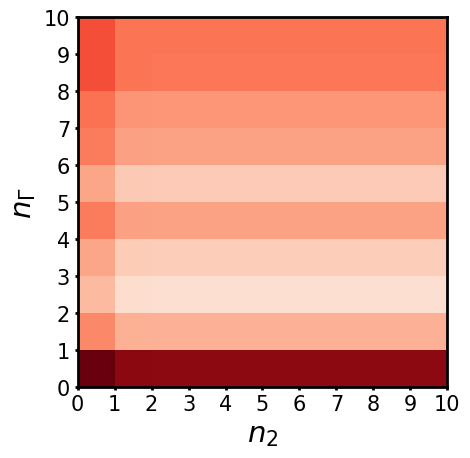

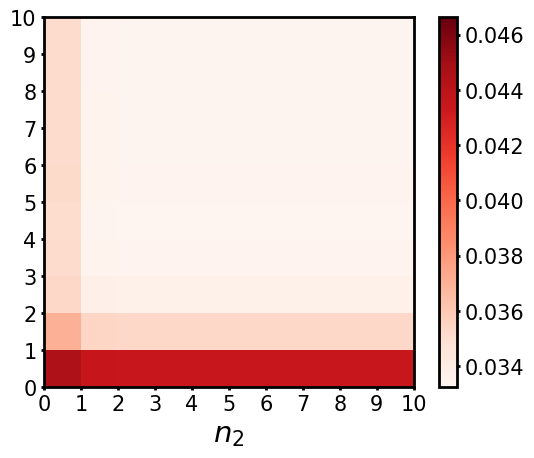

In [37]:
# Choose figures
figs = [rel_error_m_3, rel_error_m_4]
# figs = [rel_error_dom_2_m_3, rel_error_dom_2_m_4]
# figs = [rel_error_dom_I_m_3, rel_error_dom_I_m_4]
# figs = [rel_error_dom_1_m_3, rel_error_dom_1_m_4]



vmax = -10
vmin = 10

for figure in figs:
    
    maxcandidate = max(figure.flatten())
    mincandidate = min(figure.flatten())
    
    if maxcandidate > vmax:
        vmax = maxcandidate
        
    if mincandidate < vmin:
        vmin = mincandidate 


for i in range(2):
    ax = plt.figure(figsize=(6.4, 4.8)).gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    img = ax.imshow(np.flipud(figs[i]), vmin=vmin, vmax=vmax, extent=[0,cutoff2,0,cutoffI], interpolation = "nearest", cmap='Reds')
    
    if i ==1:
        plt.colorbar(img,ax=ax)
    
    plt.xlabel('$n_2$')
    if i == 0:
        plt.ylabel('$n_\Gamma$')
#     plt.savefig(saves_error[i], bbox_inches='tight')
    plt.show()

In [16]:
print(rel_error_dom_2_m_3-rel_error_dom_2_m_4)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
